# Machining Quality - Classification Model
#### Binary Classifier 
Last Updated Dec5. 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from keras.layers import LeakyReLU,PReLU
import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play
import specAugment
# from specAugment import spec_augment_tensorflow

Using TensorFlow backend.
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\py

In [2]:
# os.chdir("D:\\aircraft-audio\lax-naming-convention")
# import IPython
# from IPython.display import Image, Audio
# print("Embraer")
# Image(filename='embardier.png',width=300, height=200)

In [3]:
# Change working directory to local lcoation for this file.
os.chdir('D://machineshop')
base_dir = 'D://machineshop'
WorkingDir = os.path.join(base_dir)
print(os.getcwd())

# Check files at this folder location
import glob
filelist = glob.glob("*.txt")
print(filelist)

D:\machineshop
['new_array_currentsample_1_sec_test_justright.txt', 'new_array_currentsample_1_sec_test_toofast.txt', 'new_array_currentsample_1_sec_train_justright.txt', 'new_array_currentsample_1_sec_train_toofast.txt']


In [4]:
filelist[0]

'new_array_currentsample_1_sec_test_justright.txt'

### Load and Inspect Data

In [5]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.
print(os.getcwd())

Train_matrix_justright = np.loadtxt('new_array_currentsample_1_sec_train_justright.txt', delimiter=',')
Test_matrix_justright = np.loadtxt('new_array_currentsample_1_sec_test_justright.txt', delimiter=',')
Train_matrix_toofast = np.loadtxt('new_array_currentsample_1_sec_train_toofast.txt', delimiter=',')
Test_matrix_toofast = np.loadtxt('new_array_currentsample_1_sec_test_toofast.txt', delimiter=',')


D:\machineshop


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


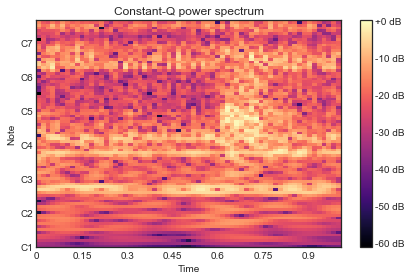

In [6]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(Train_matrix_justright[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

[ 831. -682.    0. ...  135. 1692. 2983.]


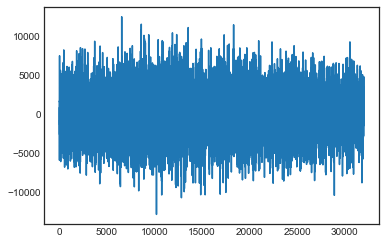

In [7]:
signal = Train_matrix_justright[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

In [8]:
# Sample Continuous Waveleet Spectrogram
# scales = np.arange(1,128)
# time = np.arange(0,32000)
# dt = time[1] - time[0]
# wavelet = 'cmor1.5-1.0'

# # Generate coefficients and frequencies
# [cfs, frequencies] = pywt.cwt(signal, scales, wavelet, dt)

# # Manipulate for spectrogram
# power = (abs(cfs)) ** 2
# period = 1. / frequencies
# #levels = 
# levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
# NewLevels = np.log2(levels)

# X = time
# Y = np.log2(period)
# Z = np.log2(power)

# plt.contourf(X, Y, Z, extend = 'both',cmap='terrain')
# #plt.colorbar();


### Add Augmented Data

In [9]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [10]:
# Create Augmented matrices with volume reduction
Augmented_Train_matrix_justright = _create_augmented_volume_reduction_data_matrix(Train_matrix_justright, -5)
Augmented_Test_matrix_justright = _create_augmented_volume_reduction_data_matrix(Test_matrix_justright, -5)
Augmented_Train_matrix_toofast = _create_augmented_volume_reduction_data_matrix(Train_matrix_toofast, -5)
Augmented_Test_matrix_toofast = _create_augmented_volume_reduction_data_matrix(Test_matrix_toofast, -5)

In [11]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [12]:
# Create Augmented matrices with white noise added
Augmented_Train_matrix_justright_2= _create_augmented_white_noise_data_matrix(Train_matrix_justright,0.01)
Augmented_Test_matrix_justright_2 = _create_augmented_white_noise_data_matrix(Test_matrix_justright,0.01)
Augmented_Train_matrix_toofast_2 = _create_augmented_white_noise_data_matrix(Train_matrix_toofast,0.01)
Augmented_Test_matrix_toofast_2 = _create_augmented_white_noise_data_matrix(Test_matrix_toofast,0.01)


### Add Labels

In [13]:
# Add labels to source matrices

Train_matrix_justright = np.c_[ np.ones(len(Train_matrix_justright)),Train_matrix_justright] 
Train_matrix_justright[:, 0] =  0
print(Train_matrix_justright.shape)

Test_matrix_justright = np.c_[ np.ones(len(Test_matrix_justright)),Test_matrix_justright] 
Test_matrix_justright[:, 0] =  0
print(Test_matrix_justright.shape)

Train_matrix_toofast = np.c_[ np.ones(len(Train_matrix_toofast)),Train_matrix_toofast] 
Train_matrix_toofast[:, 0] = 1
print(Train_matrix_toofast.shape)

Test_matrix_toofast = np.c_[ np.ones(len(Test_matrix_toofast)),Test_matrix_toofast] 
Test_matrix_toofast[:, 0] =  1
print(Test_matrix_toofast.shape)


(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)


In [14]:
#Add labels to augmented Matrices

Augmented_Train_matrix_justright = np.c_[ np.ones(len(Augmented_Train_matrix_justright)),Augmented_Train_matrix_justright] 
Augmented_Train_matrix_justright[:, 0] = 0
Augmented_Train_matrix_justright = np.delete(Augmented_Train_matrix_justright, (0), axis=0)
print(Augmented_Train_matrix_justright.shape)

Augmented_Test_matrix_justright = np.c_[ np.ones(len(Augmented_Test_matrix_justright)),Augmented_Test_matrix_justright] 
Augmented_Test_matrix_justright[:, 0] = 0
Augmented_Test_matrix_justright = np.delete(Augmented_Test_matrix_justright, (0), axis=0)
print(Augmented_Test_matrix_justright.shape)

Augmented_Train_matrix_toofast = np.c_[ np.ones(len(Augmented_Train_matrix_toofast)),Augmented_Train_matrix_toofast] 
Augmented_Train_matrix_toofast[:, 0] =1
Augmented_Train_matrix_toofast = np.delete(Augmented_Train_matrix_toofast, (0), axis=0)
print(Augmented_Train_matrix_toofast.shape)

Augmented_Test_matrix_toofast = np.c_[ np.ones(len(Augmented_Test_matrix_toofast)),Augmented_Test_matrix_toofast] 
Augmented_Test_matrix_toofast[:, 0] = 1
Augmented_Test_matrix_toofast = np.delete(Augmented_Test_matrix_toofast, (0), axis=0)
print(Augmented_Test_matrix_toofast.shape)



Augmented_Train_matrix_justright_2 = np.c_[ np.ones(len(Augmented_Train_matrix_justright_2)),Augmented_Train_matrix_justright_2] 
Augmented_Train_matrix_justright_2[:, 0] = 0
Augmented_Train_matrix_justright_2 = np.delete(Augmented_Train_matrix_justright_2, (0), axis=0)
print(Augmented_Train_matrix_justright_2.shape)

Augmented_Test_matrix_justright_2 = np.c_[ np.ones(len(Augmented_Test_matrix_justright_2)),Augmented_Test_matrix_justright_2] 
Augmented_Test_matrix_justright_2[:, 0] = 0
Augmented_Test_matrix_justright_2 = np.delete(Augmented_Test_matrix_justright_2, (0), axis=0)
print(Augmented_Test_matrix_justright_2.shape)

Augmented_Train_matrix_toofast_2 = np.c_[ np.ones(len(Augmented_Train_matrix_toofast_2)),Augmented_Train_matrix_toofast_2] 
Augmented_Train_matrix_toofast_2[:, 0] =1
Augmented_Train_matrix_toofast_2 = np.delete(Augmented_Train_matrix_toofast_2, (0), axis=0)
print(Augmented_Train_matrix_toofast_2.shape)

Augmented_Test_matrix_toofast_2 = np.c_[ np.ones(len(Augmented_Test_matrix_toofast_2)),Augmented_Test_matrix_toofast_2] 
Augmented_Test_matrix_toofast_2[:, 0] = 1
Augmented_Test_matrix_toofast_2 = np.delete(Augmented_Test_matrix_toofast_2, (0), axis=0)
print(Augmented_Test_matrix_toofast_2.shape)


(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)
(49, 32001)
(13, 32001)
(96, 32001)
(25, 32001)


### Split and Shuffle Data

In [15]:
all_train_data = []
all_test_data = []

In [16]:
all_train_data = np.append(Train_matrix_justright, Train_matrix_toofast, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_justright, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_toofast, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_justright_2, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_toofast_2, axis=0)
print(all_train_data.shape)

(145, 32001)
(194, 32001)
(290, 32001)
(339, 32001)
(435, 32001)


In [17]:
all_test_data = np.append(Test_matrix_justright, Test_matrix_toofast, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_justright, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_toofast, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_justright_2, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_toofast_2, axis=0)
print(all_test_data.shape)


(38, 32001)
(51, 32001)
(76, 32001)
(89, 32001)
(114, 32001)


In [18]:
type(all_train_data)

numpy.ndarray

In [19]:
# Shuffle rows
np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

# Seperate Labelinto y
y_train = np.asarray(all_train_data[:,0])
y_test = np.asarray(all_test_data[:,0])

#Seperate data into x
X_train = np.asarray(all_train_data[:,1:32001])
X_test = np.asarray(all_test_data[:,1:32001])

In [20]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(435,)
(435, 32000)
(114,)
(114, 32000)


### Save Intermediary Files

In [21]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [22]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_test.any(axis=1))[0]

### Slicing and Featurizing

In [23]:
mfcc_data = []

In [24]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [25]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [26]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [27]:
# plot_wavelet(time,signal)

In [28]:
train_data_cwt = 0
import tkinter
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure


In [29]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    index = 0
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # stft_data = librosa.core.stft(convert_audio_i2f(raw_data))
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        constant_q_shape_1 = constant_q.shape[1]
        constant_q_shape_0 = constant_q.shape[0]
        primary_input.append(constant_q)
        
    primary_input = np.array(primary_input).reshape(-1, constant_q_shape_0, constant_q_shape_1, 1)
    print(primary_input.shape)

    for rows in range(0,row_count):
        freq = fundamental_freq_gen(data[rows,:])
        index = index + 1
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, 11)
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [30]:
def _create_masked_spec(data, mask_freq_factor, mask_time_1, mask_time_2):

    flow = naf.Sequential([
        nas.FrequencyMaskingAug(mask_factor=mask_freq_factor), 
        nas.TimeMaskingAug(mask_factor=mask_time_1), 
        nas.TimeMaskingAug(mask_factor=mask_time_2)])
    primary_input = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)

    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        augmented_spectrogram = flow.augment(constant_q)
        
        augmented_spectrogram_shape_1 = augmented_spectrogram.shape[1]
        caugmented_spectrogram_shape_0 = augmented_spectrogram.shape[0]
        primary_input.append(augmented_spectrogram)
        
    primary_input = np.array(primary_input).reshape(-1, caugmented_spectrogram_shape_0, augmented_spectrogram_shape_1, 1)
    print(VisualSpectrogram.visual('Frequency Masking', augmented_spectrogram))
    
    
    return primary_input
        
# VisualSpectrogram.visual('Frequency Masking', augmented_mel_spectrogram)

In [31]:
import tkinter
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import nlpaug
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow 
import nlpaug.flow as naf

from nlpaug.util.file.load import LoadUtil
from nlpaug.util.visual.spectrogram import VisualSpectrogram

435


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


(435, 70, 63, 1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(435, 1, 11)
435
(435, 11)


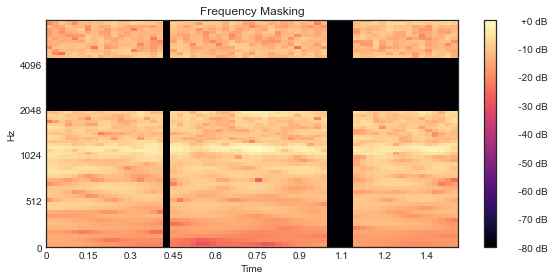

None


In [32]:
# Generate Training Features
train_cq_input, train_crepe_input = _generate_features(X_train)
train_aug_cq_input = _create_masked_spec(X_train, 30, 10, 20)

114
(114, 70, 63, 1)
(114, 1, 11)
114
(114, 11)


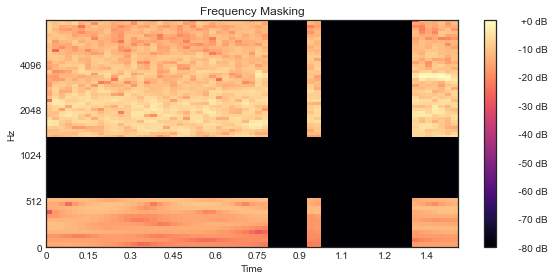

None


In [33]:
# Generate test features
test_cq_input, crepe_test_input = _generate_features(X_test)
test_aug_cq_input = _create_masked_spec(X_test, 30, 10, 20)

In [34]:
print('train input shapes')
print(train_cq_input.shape)
print(train_crepe_input.shape)
print(train_aug_cq_input.shape)
print('test input shapes')
print(test_cq_input.shape)
print(crepe_test_input.shape)
print(test_aug_cq_input.shape)

train input shapes
(435, 70, 63, 1)
(435, 11)
(435, 70, 63, 1)
test input shapes
(114, 70, 63, 1)
(114, 11)
(114, 70, 63, 1)


In [35]:
#Define Single input shape
cq_input_shape = train_cq_input[0].shape
print("CQT Shape",cq_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)
aug_cq_shape = train_aug_cq_input[0].shape
print("Aug CQ Input Shape", aug_cq_shape)


CQT Shape (70, 63, 1)
Crepe Input Shape (11,)
Aug CQ Input Shape (70, 63, 1)


In [36]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [37]:
os.chdir(base_dir)
print(os.getcwd())

D:\machineshop


### Model Building

#### Model Architecture

In [461]:
def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)

   
    inp = Input(shape=cq_input_shape)
    img_1 = LeakyReLU(alpha=0.2)(inp)
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),         
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = Dropout(0.1)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),            
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.1)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.1)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),          
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.1)(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),            
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)   
    
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(256, kernel_regularizer = regularizers.l2(0.001))(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = Dense(128, kernel_regularizer = regularizers.l2(0.001))(img_1)
    img_1 = Dropout(0.3)(img_1) 

    inp2 = Input(shape=aug_cq_shape)
    img_2 = LeakyReLU(alpha=0.2)(inp2)
    img_2 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)

    
    img_2 = Conv2D(32, kernel_size=(3,3),       
                    kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                    use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
        
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    
    img_2 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    
    img_2 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4,          
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)  
    
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = Flatten()(img_2)
    img_2 = Dense(256)(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = Dense(34)(img_2)
    img_2 = Dropout(0.5)(img_2)  
    
    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = LeakyReLU(alpha=0.2)(crepe_inp)
    
    crepe_dense = Dense(24,  kernel_initializer=initializer4, 
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_dense)
    crepe_dense = Dropout(0.1)(crepe_dense)   
    
    concat_layer = keras.layers.concatenate([img_1, img_2, crepe_dense])
    concat_dense = LeakyReLU(alpha=0.2)(concat_layer)
    concat_dense = Dense(16, kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_dense)
    concat_dense = Dropout(0.3)(concat_dense)
    concat_dense = Dense(12, kernel_regularizer = regularizers.l2(0.001))(concat_dense)
    
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, inp2, crepe_inp], outputs=[output_layer])
    opt = optimizers.Adam(lr=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.0001, amsgrad=True)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    
    return model

In [462]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}

In [463]:
cq_crepe_model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_183 (InputLayer)          (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
input_184 (InputLayer)          (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_859 (LeakyReLU)     (None, 70, 63, 1)    0           input_183[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_865 (LeakyReLU)     (None, 70, 63, 1)    0           input_184[0][0]                  
__________________________________________________________________________________________________
conv2d_628

In [464]:
mcp_save = ModelCheckpoint('best_machine_tooling_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [465]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.0000001)


In [466]:
history = cq_crepe_model.fit([train_cq_input, train_aug_cq_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=300,verbose=1, batch_size=18,
                         validation_data=([test_cq_input, test_aug_cq_input,crepe_test_input], to_categorical(y_test)), 
                         callbacks=[reduce_lr], shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)

Train on 435 samples, validate on 114 samples
Epoch 1/300
435/435 [==============================] - 45s 103ms/step - loss: 16.3280 - acc: 0.3667 - val_loss: 11.7081 - val_acc: 0.2763
Epoch 2/300
435/435 [==============================] - 2s 4ms/step - loss: 15.9926 - acc: 0.3805 - val_loss: 11.8399 - val_acc: 0.2763
Epoch 3/300
435/435 [==============================] - 2s 4ms/step - loss: 16.1763 - acc: 0.3770 - val_loss: 11.6803 - val_acc: 0.3026
Epoch 4/300
435/435 [==============================] - 2s 4ms/step - loss: 15.8251 - acc: 0.3828 - val_loss: 11.5250 - val_acc: 0.3026
Epoch 5/300
435/435 [==============================] - 2s 4ms/step - loss: 15.0482 - acc: 0.4069 - val_loss: 11.3065 - val_acc: 0.3289
Epoch 6/300
435/435 [==============================] - 2s 4ms/step - loss: 15.0530 - acc: 0.4057 - val_loss: 11.2682 - val_acc: 0.3421
Epoch 7/300
435/435 [==============================] - 2s 4ms/step - loss: 15.1348 - acc: 0.4000 - val_loss: 11.3977 - val_acc: 0.3158
Epoch 

435/435 [==============================] - 2s 4ms/step - loss: 1.0714 - acc: 0.9839 - val_loss: 0.6967 - val_acc: 1.0000
Epoch 62/300
435/435 [==============================] - 2s 4ms/step - loss: 0.9076 - acc: 0.9920 - val_loss: 1.1203 - val_acc: 0.9737
Epoch 63/300
435/435 [==============================] - 2s 4ms/step - loss: 1.0243 - acc: 0.9931 - val_loss: 1.1198 - val_acc: 0.9737
Epoch 64/300
435/435 [==============================] - 2s 4ms/step - loss: 0.9762 - acc: 0.9920 - val_loss: 0.6958 - val_acc: 1.0000
Epoch 65/300
435/435 [==============================] - 2s 4ms/step - loss: 1.3209 - acc: 0.9736 - val_loss: 0.8650 - val_acc: 0.9868
Epoch 66/300
435/435 [==============================] - 2s 4ms/step - loss: 1.0855 - acc: 0.9839 - val_loss: 0.6953 - val_acc: 1.0000
Epoch 67/300
435/435 [==============================] - 2s 4ms/step - loss: 1.0010 - acc: 0.9874 - val_loss: 0.6948 - val_acc: 1.0000
Epoch 68/300
435/435 [==============================] - 2s 4ms/step - loss:

435/435 [==============================] - 2s 4ms/step - loss: 0.8439 - acc: 0.9931 - val_loss: 0.6767 - val_acc: 1.0000
Epoch 123/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8435 - acc: 0.9931 - val_loss: 0.6763 - val_acc: 1.0000
Epoch 124/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8988 - acc: 0.9908 - val_loss: 0.6760 - val_acc: 1.0000
Epoch 125/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8716 - acc: 0.9920 - val_loss: 0.6756 - val_acc: 1.0000
Epoch 126/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6755 - acc: 1.0000 - val_loss: 0.6753 - val_acc: 1.0000
Epoch 127/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6752 - acc: 1.0000 - val_loss: 0.6750 - val_acc: 1.0000
Epoch 128/300
435/435 [==============================] - 2s 4ms/step - loss: 0.7665 - acc: 0.9977 - val_loss: 0.6748 - val_acc: 1.0000
Epoch 129/300
435/435 [==============================] - 2s 4ms/step 

Epoch 183/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8250 - acc: 0.9931 - val_loss: 0.6578 - val_acc: 1.0000
Epoch 184/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8247 - acc: 0.9931 - val_loss: 0.6576 - val_acc: 1.0000
Epoch 185/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6851 - acc: 0.9989 - val_loss: 0.6573 - val_acc: 1.0000
Epoch 186/300
435/435 [==============================] - 2s 4ms/step - loss: 0.7961 - acc: 0.9943 - val_loss: 0.6570 - val_acc: 1.0000
Epoch 187/300
435/435 [==============================] - 2s 4ms/step - loss: 0.7682 - acc: 0.9954 - val_loss: 0.6567 - val_acc: 1.0000
Epoch 188/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8236 - acc: 0.9931 - val_loss: 0.6564 - val_acc: 1.0000
Epoch 189/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8233 - acc: 0.9931 - val_loss: 0.6561 - val_acc: 1.0000
Epoch 190/300
435/435 [==============================] 

435/435 [==============================] - 2s 4ms/step - loss: 0.6428 - acc: 1.0000 - val_loss: 0.6427 - val_acc: 1.0000
Epoch 244/300
435/435 [==============================] - 2s 4ms/step - loss: 0.8096 - acc: 0.9931 - val_loss: 0.6425 - val_acc: 1.0000
Epoch 245/300
435/435 [==============================] - 2s 4ms/step - loss: 0.7257 - acc: 0.9966 - val_loss: 0.6422 - val_acc: 1.0000
Epoch 246/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6978 - acc: 0.9977 - val_loss: 0.6420 - val_acc: 1.0000
Epoch 247/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6976 - acc: 0.9977 - val_loss: 0.6418 - val_acc: 1.0000
Epoch 248/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6973 - acc: 0.9977 - val_loss: 0.6415 - val_acc: 1.0000
Epoch 249/300
435/435 [==============================] - 2s 4ms/step - loss: 0.6691 - acc: 0.9989 - val_loss: 0.6413 - val_acc: 1.0000
Epoch 250/300
435/435 [==============================] - 2s 4ms/step 

In [467]:
# Save Model
#cq_crepe_model.save('_Model_Machine_Tooling_12_3.h5')

#### Graph the results

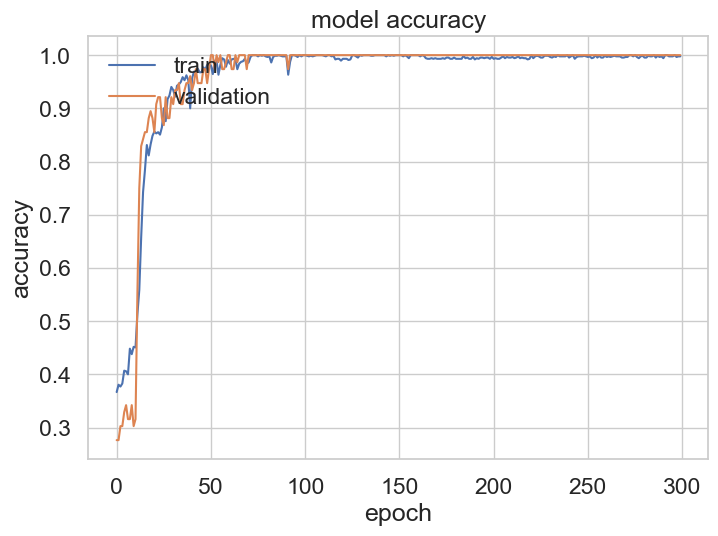

In [468]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


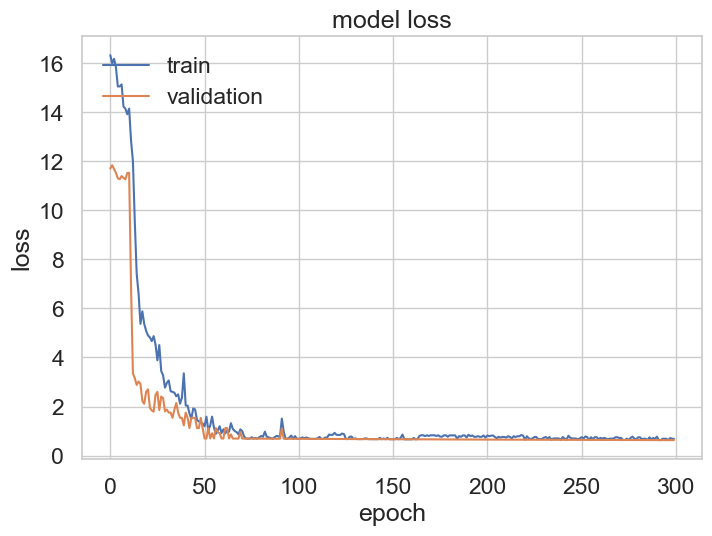

In [469]:
# "Loss"
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [470]:
cq_crepe_model.evaluate([test_cq_input, test_aug_cq_input, crepe_test_input],y_test_labels)

114/114 [==============================] - 0s 1ms/step


[0.6304644346237183, 1.0]

#### Confusion Matrix

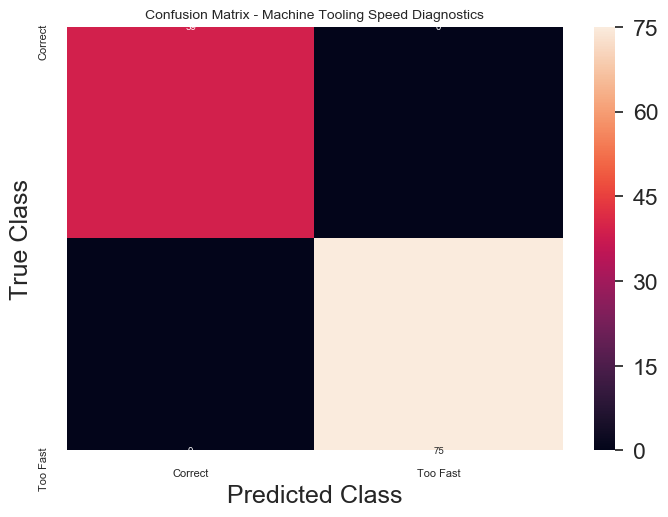

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        39
        1.0       1.00      1.00      1.00        75

avg / total       1.00      1.00      1.00       114



In [471]:
plt.style.use('default')
#plt.margins(1)
import matplotlib as mpl
import importlib
import matplotlib
import seaborn as sns

sns.set()
plt.style.use('seaborn')    
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   

preds =np.argmax(cq_crepe_model.predict([test_cq_input, test_aug_cq_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

sns.set(style="whitegrid", font_scale=1.5) 
akws = {"ha": 'center',"va": 'center', 'size':7}
ax = sns.heatmap(cm,  annot=True, fmt='d',annot_kws=akws)

ax.set_title('Confusion Matrix - Machine Tooling Speed Diagnostics', fontsize=10)
ax.xaxis.set_ticklabels(['Correct', 'Too Fast'], fontsize=8)
ax.yaxis.set_ticklabels(['Correct', 'Too Fast'], fontsize=8)
ax.set(xlabel='Predicted Class', ylabel='True Class')

    
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [472]:
cm

array([[39,  0],
       [ 0, 75]], dtype=int64)

# The End